# Synchornization in complete networks of neurons
Here is the equation of neurons potentails dynamics:
$$
\dot{v_i}=a_i - v_i - \frac{g}{N} \sum_{n|t_n<t} S_{i,l(n)} \delta(t - t_n - t_d) 
$$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Constants and parameters:

In [2]:
num_neurons = 1000
g = 5
random_input_span = (1.2,2.8)

total_time = 1000
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

potentail_arr = np.zeros(num_neurons,dtype = float)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )

In [4]:
saving_path_name = 'single_runs'
current_version = 'N{}_T{}_g{}_input_{}_{}'.format(num_neurons,total_time,g,random_input_span[0],random_input_span[1])
try:
    saving_path = os.path.join(saving_path_name, current_version) 
    os.makedirs(saving_path)
except:
    pass

## Instrumentes to capture spiking frequency
Here we use *cornometer* and number of spikies to measure their frequencies.

In [5]:
spiking_cornometer = np.zeros(num_neurons)
total_spikes_intervals = np.zeros(num_neurons)
total_spikes_num = np.zeros(num_neurons)

### Useful functions:

In [6]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0

## Solving the differential equation

In [7]:
for i in tqdm( range(total_steps) ):
    potentail_arr = potentail_arr + (random_input - potentail_arr)*time_step - (g/num_neurons)*retarded_spikes_record(i)
    spiking_records[i] = potentail_arr > 1
    potentail_arr = potentail_arr - 1 * spiking_records[i]
    #frequency calculator
    total_spikes_num = total_spikes_num + spiking_records[i]
    total_spikes_intervals = total_spikes_intervals + spiking_cornometer * spiking_records[i] #add to spike lapsed time
    spiking_cornometer = spiking_cornometer * (spiking_records[i]-1)*(-1) #reset the spikied cornos
    spiking_cornometer = spiking_cornometer + (spiking_records[i]-1)*(-1) #update the not spikied ones

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:18<00:00, 5491.02it/s]


In [8]:
plt.rc('font', family='serif')

(array([ 74.,  86., 124.,  71., 102., 143., 105., 112., 135.,  48.]),
 array([-0.2248565 , -0.11812549, -0.01139449,  0.09533652,  0.20206753,
         0.30879853,  0.41552954,  0.52226055,  0.62899155,  0.73572256,
         0.84245357]),
 <BarContainer object of 10 artists>)

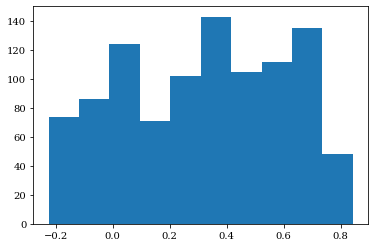

In [9]:
plt.hist(potentail_arr)

# Measuring E (effective field):
we can measure if the total network is synchronized. let's define E as following:

$$
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
$$

To do so, we define $M$ as $M = \dot{E} + \alpha E$. As a result we wil have the following systems of equation:
\begin{equation}
    \begin{cases}
      \dot{E} = M - \alpha E\\
      \dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
    \end{cases}\,.
\end{equation}


In [10]:
alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

In [11]:
for i in tqdm(range(0,total_steps-1)):
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )

100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:04<00:00, 21086.02it/s]


Text(0.5, 1.0, 'E')

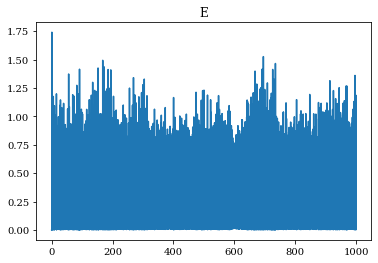

In [12]:
plt.plot(time_span,e_arr)
plt.title('E')

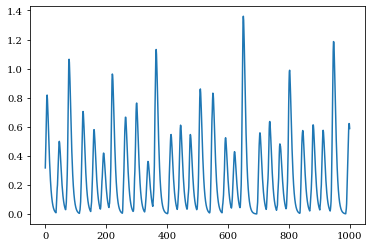

In [13]:
plt.plot(e_arr[-1000:])

In [14]:
sigma = np.std( e_arr )
sigma

0.2419181093172853

# Rasterplot

In [32]:
thicker_spike_records = np.copy(spiking_records)
row, column = np.where(spiking_records == True)
r = 100
for i,j in zip(row,column):
    for x in np.arange(-r,r+1):
        for y in np.arange(r-abs(x),abs(x)-r):
            thicker_spike_records[i+x,j+y] = True

C:\Users\mohsen\AppData\Local\Temp\ipykernel_8476\2174209352.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


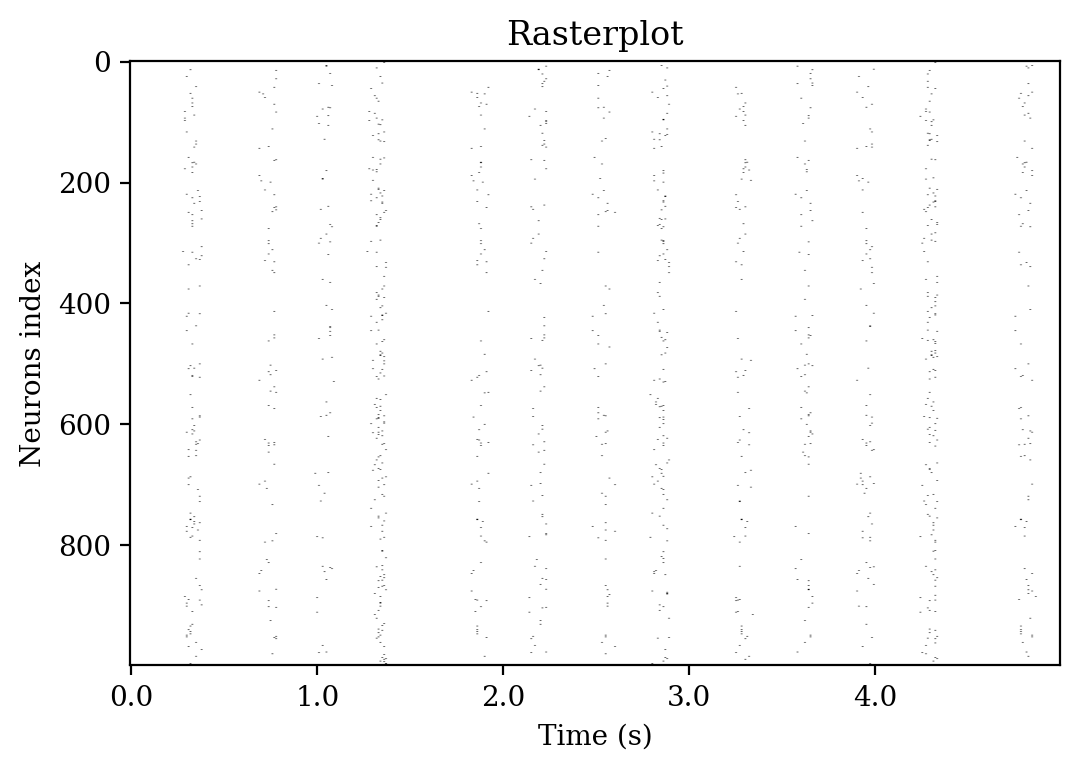

In [33]:
fig = plt.figure(dpi = 200)
# fig = plt.figure()
ax = fig.add_subplot()

ax.imshow( thicker_spike_records[-500:,:].T,aspect= 'auto', cmap = 'binary')
# ax.imshow( spiking_records[-500:,:].T,extent = [0, 5, 0, 10],aspect = 1, cmap = 'binary')
ax.set_ylabel('Neurons index')
ax.set_xlabel('Time (s)')
ax.set_title('Rasterplot')

fig.canvas.draw()
labels = ax.get_xticks().tolist()
labels = [x*time_step for x in labels]
ax.set_xticklabels(labels)

# plt.savefig('raster_plot_N{}.png'.format(num_neurons))
fig.savefig(os.path.join(saving_path, 'raster_plot.png'))

In [17]:
labels

[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

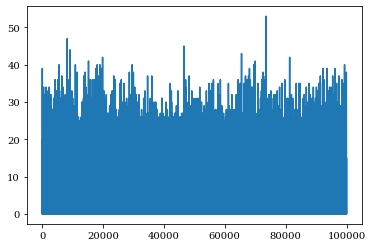

In [18]:
plt.plot(np.sum( spiking_records, axis = 1))

## Calculate frequency

In [19]:
spikies_freq_neurons = total_spikes_intervals * time_step / total_spikes_num
spikies_freq_neurons

C:\Users\mohsen\AppData\Local\Temp\ipykernel_8476\77605990.py:1: RuntimeWarning: invalid value encountered in true_divide
  spikies_freq_neurons = total_spikes_intervals * time_step / total_spikes_num


array([         nan,          nan,   3.45989583,          nan,
                nan,          nan,          nan,   1.8588785 ,
         1.2197909 ,          nan,          nan,   1.78181004,
                nan,   1.9604142 ,   1.64069421,   1.80032609,
                nan,          nan,          nan,          nan,
         1.27693299,   2.09820675,          nan,          nan,
                nan,   1.20228155,          nan,          nan,
                nan,   1.44365357,          nan,   2.95988095,
       231.80666667,   2.13901075,          nan,          nan,
         2.33981176,   1.23667082,          nan,          nan,
         1.27860645,   3.13791798,   1.78670863,   1.11406074,
                nan,   1.6639196 ,          nan,          nan,
                nan,          nan,          nan,   1.05367021,
                nan,   1.3961744 ,   1.19689614,          nan,
                nan,   1.77541071,          nan,          nan,
         1.0793566 ,   1.08027263,          nan,       

(array([429.,   4.,   2.,   0.,   4.,   0.,   3.,   0.,   0.,   2.]),
 array([  1.04150526,  35.70885474,  70.37620421, 105.04355368,
        139.71090316, 174.37825263, 209.04560211, 243.71295158,
        278.38030105, 313.04765053, 347.715     ]),
 <BarContainer object of 10 artists>)

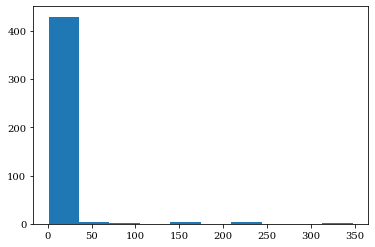

In [20]:
plt.hist(spikies_freq_neurons)